# Funciones Auxiliares

In [1]:
from datetime import datetime

# 14:15:00 --> 14,25
def convertir_hora_a_double(string_hora):
    time_obj = datetime.strptime(string_hora, '%H:%M:%S').time()
    hora, minuto, segundo = time_obj.hour, time_obj.minute, time_obj.second 
    return round(hora + minuto / 60 + segundo / 3600, 2)

# Lectura y Procesamiento de datos
## Todos los datos

In [2]:
import os, gzip
import numpy as np
import pandas as pd

# Directorio conteniendo los datos
directory = 'data'

dfs = []
# Recorremos los archivos del directorio
for filename in os.listdir(directory):
    if filename.endswith('.txt.gz'):
        raw_data = []
        read_line = False
        with gzip.open(directory + '/' + filename, 'rb') as f:
            lines = f.readlines()
            lines = [item.decode('utf-8') for item in lines]
            for line in lines:
                if line.startswith("#"):
                    read_line = True
                    continue
                if read_line:
                    raw_data.append(line.replace('\t\r\n', ''))
        dfs.append(pd.DataFrame([x.split('\t') for x in raw_data]))
        
dataframe = pd.concat(dfs)

# Leemos y asignamos los nombres de las columnas
with open('headers.txt') as h:
    headers = [item for item in h.read().split('\n')[0].split(',')]
dataframe.columns = headers

# Observar caracteristicas de los datos
dataframe.describe()

fecha      hora    marca     temp   luz_v1   luz_v2        x  \
count    1605960   1605960  1605960  1605960  1605960  1605960  1605960   
unique       271     69120        8      274    28211    21261     1799   
top     05/10/18  03:18:30        0     33.8     0.00     0.00     -1.1   
freq       33120       240  1081439    35267   543240   578991     2681   

              y        z     suma  suma_ac    t_mov  luz_ir1  luz_ir2  \
count   1605960  1605960  1605960  1605960  1605960  1605960  1605960   
unique     1800     1802    19261    13940      300    16507    43787   
top         0.0      5.8      187     0.91      0.0     0.00     0.00   
freq       4224     1982     7116     5869   565267   609910   523438   

        suma_ax  suma_ay  suma_az  
count   1605960  1605960  1605960  
unique     3438     3967     3116  
top         5.6      0.6    298.4  
freq       1224     1809     2218

## Filtrado de datos


In [3]:
# Para evitar warnings
pd.options.mode.chained_assignment = None

marcas_validas = ['0', '2', '4', '6', '8', '10']
valid_data = dataframe[dataframe['marca'].isin(marcas_validas)]

valid_data['hora'] = np.array([convertir_hora_a_double(item) for item in valid_data['hora']])

valid_data.to_csv('valid_data.csv', index=False)

# Para leerlo luego...
# data = pd.read_csv('valid_data.csv')

valid_data.head()

fecha   hora marca  temp luz_v1 luz_v2     x     y     z  suma suma_ac  \
0  23/06/17  11.13     0  25.5  299.0  50.86  -1.1   1.1  88.4  2184    9.78   
1  23/06/17  11.14     0  25.6  325.0  55.23  -1.2   1.1  88.3   259    1.44   
6  23/06/17  11.18     0  26.1  179.0  33.25  14.4  -6.0  74.2  3839   14.29   
7  23/06/17  11.19     0  27.4  129.0  20.51  73.5   3.1  16.1  3487   10.88   
8  23/06/17  11.20     0  28.1  250.0  42.29  24.6  -1.3  65.3   852    2.60   

   t_mov luz_ir1 luz_ir2 suma_ax suma_ay suma_az  
0   51.0     3.0   340.0    16.0    17.1   294.4  
1    9.0     4.0   350.0     5.4     6.4   299.5  
6  163.0     2.0   466.0    58.3    38.5   283.8  
7  197.0     1.0   455.0   249.5    28.2   119.7  
8   47.0     3.0   479.0   189.0     9.1   190.2

# Datos Población

In [4]:
lengths = [len(x) for x in dfs]
print(f'Media de observaciones por paciente: {round(np.mean(lengths), 2)} observaciones/paciente')

Media de observaciones por paciente: 18893.65 observaciones/paciente


In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

# Plot de los resultados
fig, ax = plt.subplots(figsize=(12,6))

n, bins, patches = ax.hist(x=lengths, bins=20,
                            alpha=0.7, rwidth=0.85)
ax.grid()

ax.set_yticks(list(np.arange(0, max(n) + 10, 5)))

plt.xlabel('Número de observaciones')
plt.ylabel('Frecuencia')
plt.suptitle('Número de observaciones por paciente', fontsize=20)
plt.savefig('plots/obs.png')

In [6]:
plt.figure(figsize=(12,6))

labels, counts = np.unique(valid_data['marca'].astype(int), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(np.arange(0, 12, 2))

plt.xlabel('Marca')
plt.ylabel('Frecuencia')
plt.suptitle('Registro de valores de marca', fontsize=20)

plt.savefig('plots/marcas.png')

# PCA

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca_out = PCA()
data_pca = pca_out.fit_transform(valid_data.drop(columns=['marca', 'fecha']))

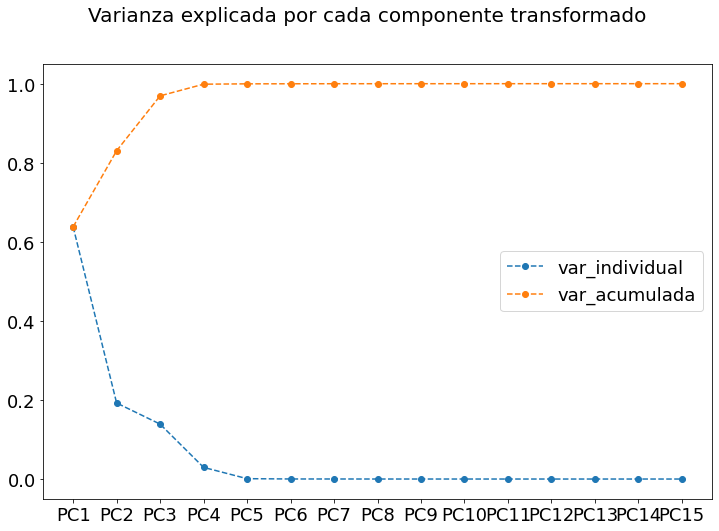

In [8]:
num_pc = pca_out.n_features_

pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]

plt.figure(figsize=(12,8))
plt.plot(pc_list, pca_out.explained_variance_ratio_, 'o--', label='var_individual')

plt.plot(pc_list, np.cumsum(pca_out.explained_variance_ratio_), 'o--', label='var_acumulada')

plt.suptitle('Varianza explicada por cada componente transformado', fontsize=20)
plt.legend()
plt.savefig('plots/pca.png')
plt.show()

In [9]:
pca_out = PCA()
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(valid_data.drop(columns=['marca', 'fecha']))
data_pca_sc = pca_out.fit_transform(data_sc)

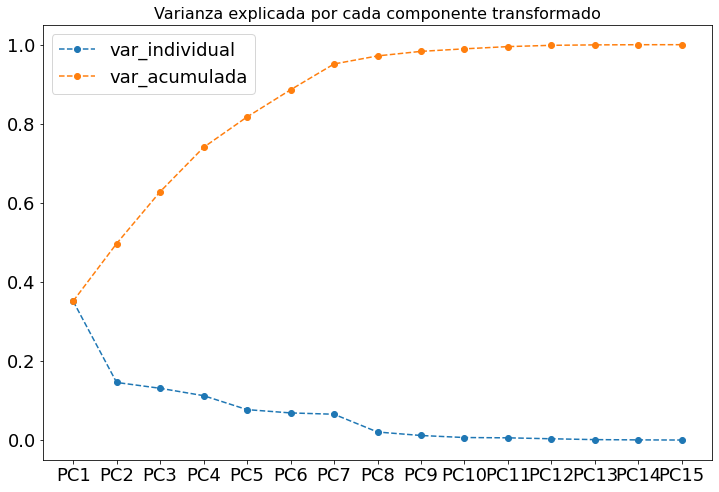

In [10]:
num_pc = pca_out.n_features_

pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]

plt.figure(figsize=(12,8))
plt.plot(pc_list, pca_out.explained_variance_ratio_, 'o--', label='var_individual')

plt.plot(pc_list, np.cumsum(pca_out.explained_variance_ratio_), 'o--', label='var_acumulada')

plt.title('Varianza explicada por cada componente transformado', fontsize=16)
plt.legend()
plt.savefig('plots/pca-sc.png')
plt.show()

# Diurno

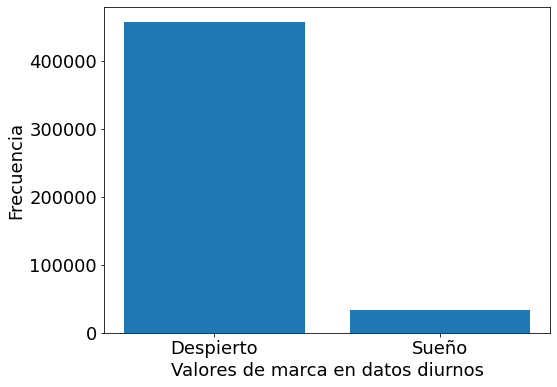

In [11]:
reducir_marca = lambda x : '0' if x == '0' else '2'

mask = (12 <= valid_data['hora']) & (valid_data['hora']<= 20)
sleep_data = valid_data.loc[mask]

sleep_data['marca'] = sleep_data['marca'].apply(reducir_marca)
labels, counts = np.unique(sleep_data['marca'], return_counts=True)

plt.figure(figsize=(8,6))

plt.bar(labels, counts, align='center')
plt.xticks([0,1], labels=['Despierto', 'Sueño'])

plt.xlabel('Valores de marca en datos diurnos')
plt.ylabel('Frecuencia')

plt.savefig('plots/sueno.png')